# Setup

In [0]:
# !pip install tensorflow-gpu==2.0.0
# !apt-get install -y xvfb
# !pip install 'gym==0.10.11'
# !pip install 'imageio==2.4.0'
# !pip install PILLOW
# !pip install 'pyglet==1.3.2'
!pip install pyvirtualdisplay

     |████████████████████████████████| 380.8MB 38kB/s 
     |████████████████████████████████| 3.8MB 30.7MB/s 
     |████████████████████████████████| 450kB 48.4MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exis

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 783 kB in 1s (627 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.3_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.3) ...
Setting up xvfb (2:1.19.6-1ubuntu4.3) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
     |████████████████████████████████| 1.5MB 4.5MB/s 
  Created wheel for gym: filename=

In [4]:
# imports for virtual display, jupyter notebook only
import base64
import IPython
import PIL.Image
import pyvirtualdisplay

In [8]:
import random
import numpy as np
import gym
import imageio
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

In [6]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [3]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# DQN 

Paper: https://arxiv.org/pdf/1312.5602.pdf

In [9]:
class DQN:
    def __init__(
            self, 
            env, 
            memory_len=1000,
            time_steps=4,
            gamma=0.85,
            epsilon=1.0,
            epsilon_decay=0.995,
            epsilon_min=0.01,
            learning_rate=0.0001,
            tau=0.125
    ):
        self.env     = env
        self.memory  = deque(maxlen=memory_len)
        self.state_shape  = env.observation_space.shape
        self.time_steps = time_steps
        self.stored_states = np.zeros((self.time_steps, self.state_shape[0]))
        
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.tau = tau

        self.model        = self.create_model()
        self.target_model = self.create_model()
        self.rewards = [0]
        self.q_values = []

    def create_model(self):
        model   = Sequential()
        model.add(LSTM(24, input_shape=(self.time_steps, self.state_shape[0]), activation="tanh"))
        model.add(Dense(16))
        model.add(Dense(self.env.action_space.n))
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=self.learning_rate))
        return model
    
    def update_states(self, new_state):
        self.stored_states = np.roll(self.stored_states, -1, axis=0)
        self.stored_states[-1] = new_state

    def act(self, test=False):
        states = self.stored_states.reshape((1, self.time_steps, self.state_shape[0]))
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        epsilon = 0.01 if test else self.epsilon
        q_values = self.model.predict(states)[0]
        self.q_values.append(max(q_values))
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(q_values)

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        batch_states = []
        batch_target = []
        for sample in samples:
            states, action, reward, new_states, done = sample
            batch_states.append(states)
            states = states.reshape((1, self.time_steps, self.state_shape[0]))
            target = self.target_model.predict(states)[0]
            if done:
                target[action] = reward
            else:
                new_states = new_states.reshape((1, self.time_steps, self.state_shape[0]))
                Q_future = max(self.target_model.predict(new_states)[0])
                target[action] = reward + Q_future * self.gamma
            batch_target.append(target)
        self.model.fit(np.array(batch_states), np.array(batch_target), epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save(fn)

    def load_model(self, fn):
        self.model = tf.keras.models.load_model(fn)
        self.target_model = self.model

    def train(self, epoches=10000, max_episodes=10, max_steps=500):
        done, episode, steps = True, 0, 0
        for ep in tqdm(range(epoches)):
            if steps >= max_steps:
                print("Episode {}, reached max step at {} epoches".format(episode, epoches))
                self.save_model("dqn_basic_episode{}.h5".format(episode))
                break
            if episode >= max_episodes:
                break
            if done:
                self.stored_states = np.zeros((self.time_steps, self.state_shape[0]))
                done, cur_state, steps = False, self.env.reset(), 0
                episode += 1
                self.rewards.append(0)
            action = self.act()
            new_state, reward, done, _ = self.env.step(action)
            modified_reward = 1 - abs(new_state[2] / (np.pi / 2)) # divide by 90 degrees
            cur_stored_states = self.stored_states
            self.update_states(new_state)
            self.remember(cur_stored_states, action, modified_reward, self.stored_states, done)
            self.replay() # internally iterates default (prediction) model
            self.target_train() # iterates target model

            self.rewards[-1] += reward
            steps += 1

    def test(self, render=True, fps=30, filename='test_render.mp4'):
        cur_state, done, rewards = self.env.reset(), False, 0
        with imageio.get_writer(filename, fps=fps) as video:
            while not done:
                action = self.act(test=True)
                new_state, reward, done, _ = self.env.step(action)
                self.update_states(new_state)
                rewards += reward
                if render:
                    video.append_data(self.env.render(mode='rgb_array'))
        print("Total rewards: ", rewards)

    def plot_q_values(self):
        plt.plot(self.q_values, label="Q value")
        plt.legend(loc="upper right")
        plt.show()

    def plot_rewards(self):
        plt.plot(self.rewards, label="Reward")
        plt.legend(loc="upper right")
        plt.show()

# Training

In [10]:
env = gym.make('Breakout-ram-v0')
# env._max_episode_steps = 500
dqn_agent = DQN(env)

DependencyNotInstalled: No module named 'atari_py'. (HINT: you can install Atari dependencies by running 'pip install gym[atari]'.)

In [7]:
!pip3 install gym[atari]

     |████████████████████████████████| 3.5MB 111kB/s eta 0:00:01
     |████████████████████████████████| 2.4MB 2.7MB/s eta 0:00:01


In [ ]:
dqn_agent.train(epoches=700, max_episodes=40)

 81%|████████  | 567/700 [18:38<05:23,  2.43s/it]

In [5]:
dqn_agent.save_model("lstm_dqn_ts4.h5")

In [70]:
dqn_agent.load_model("lstm_dqn_improved.h5")

In [71]:
dqn_agent.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24)                2784      
_________________________________________________________________
dense (Dense)                (None, 16)                400       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 3,218
Trainable params: 3,218
Non-trainable params: 0
_________________________________________________________________


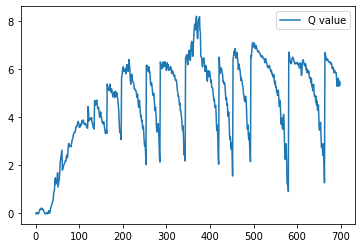

In [6]:
dqn_agent.plot_q_values()

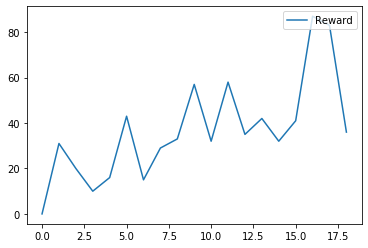

In [7]:
dqn_agent.plot_rewards()

In [10]:
dqn_agent.test(env)

Total rewards:  103.0


In [74]:
embed_mp4('test_render.mp4')

NameError: name 'embed_mp4' is not defined